In [1]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d ashishjangra27/face-mask-12k-images-dataset

 97% 320M/330M [00:06<00:00, 39.7MB/s]
100% 330M/330M [00:06<00:00, 54.4MB/s]


In [ ]:
!unzip *.zip && rm -rf *.zip

#Dataset Preprocessing

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
ImageDataGenerator??

In [30]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.1,
    fill_mode="nearest",
    rotation_range=90,
    width_shift_range=0.1,
    height_shift_range=0.1
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

train_generator = train_datagen.flow_from_directory(
    "/content/Face Mask Dataset/Train",
    target_size=(64, 64),
    batch_size=64,
    color_mode="rgb",
    class_mode="binary"
)
test_generator = test_datagen.flow_from_directory(
    "/content/Face Mask Dataset/Test",
    target_size=(64, 64),
    batch_size=64,
    color_mode="rgb",
    class_mode="binary"
)
val_generator = test_datagen.flow_from_directory(
    "/content/Face Mask Dataset/Validation",
    target_size=(64, 64),
    batch_size=64,
    color_mode="rgb",
    class_mode="binary"
)

Found 10000 images belonging to 2 classes.
Found 992 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [14]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential

In [15]:
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(3, 3), input_shape=(64, 64, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=256, kernel_size=(3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(units=1024, activation="relu"))
model.add(Dropout(rate=0.2))
model.add(Dense(units=512, activation="relu"))
model.add(Dropout(rate=0.2))
model.add(Dense(units=1, activation="sigmoid"))

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 62, 62, 64)        1792      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 29, 29, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 12, 12, 128)       147584    
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 6, 6, 128)       

In [17]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint(
    "pneumonia_model.h5",
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    verbose=1
)

earlystop = EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=3,
    verbose=1,
    restore_best_weights=True
)
callbacks = [earlystop, checkpoint]

In [19]:
history = model.fit(
  train_generator,
  epochs = 100,
  callbacks=callbacks,
  validation_data=test_generator
)

Epoch 1/100
157/157 [==============================] - ETA: 0s - loss: 0.3231 - accuracy: 0.8680
Epoch 1: val_loss improved from inf to 0.27745, saving model to pneumonia_model.h5
157/157 [==============================] - 42s 203ms/step - loss: 0.3231 - accuracy: 0.8680 - val_loss: 0.2775 - val_accuracy: 0.8982
Epoch 2/100
157/157 [==============================] - ETA: 0s - loss: 0.2517 - accuracy: 0.9012
Epoch 2: val_loss improved from 0.27745 to 0.25669, saving model to pneumonia_model.h5
157/157 [==============================] - 32s 204ms/step - loss: 0.2517 - accuracy: 0.9012 - val_loss: 0.2567 - val_accuracy: 0.9002
Epoch 3/100
157/157 [==============================] - ETA: 0s - loss: 0.2340 - accuracy: 0.9107
Epoch 3: val_loss did not improve from 0.25669
157/157 [==============================] - 32s 201ms/step - loss: 0.2340 - accuracy: 0.9107 - val_loss: 0.2712 - val_accuracy: 0.8982
Epoch 4/100
157/157 [==============================] - ETA: 0s - loss: 0.2158 - accuracy: 

#Visualization

In [44]:
import matplotlib.pyplot as plt

def plot_generator(generator):
  plt.figure(figsize=[15,15])
  images, labels = next(generator)
  for i in range(5 * 5):
      plt.subplot(5,5,i+1)
      plt.imshow(images[i])
      plt.title(labels[i])
      plt.axis("off")
  plt.show()

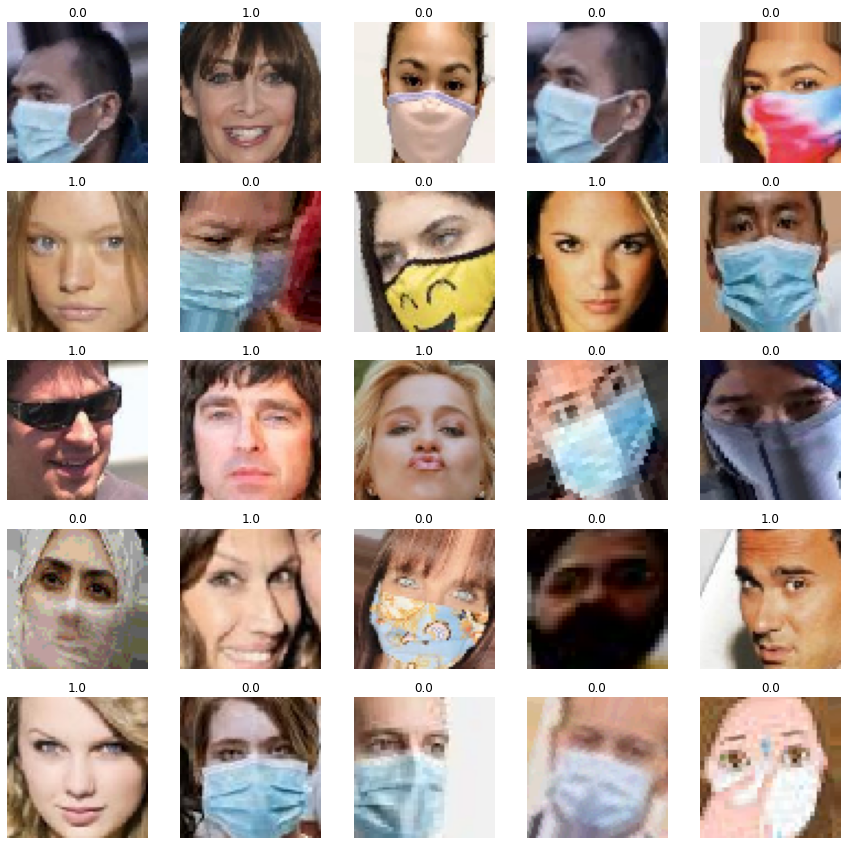

In [46]:
plot_generator(test_generator)

In [42]:
import matplotlib.pyplot as plt
import tensorflow as tf

def plot_generator_predictions(generator):
  plt.figure(figsize=[15,15])
  images, labels = next(generator)
  for i in range(5 * 5):
      output = None
      plt.subplot(5,5,i+1)
      plt.imshow(images[i])
      prediction = model.predict(tf.expand_dims(images[i], 0))
      if prediction > 0.5:
        output = "NotMask"
      else:
        output = "Mask"
      plt.title(f"Prediction: {output}")
      plt.axis('off')
  plt.show()

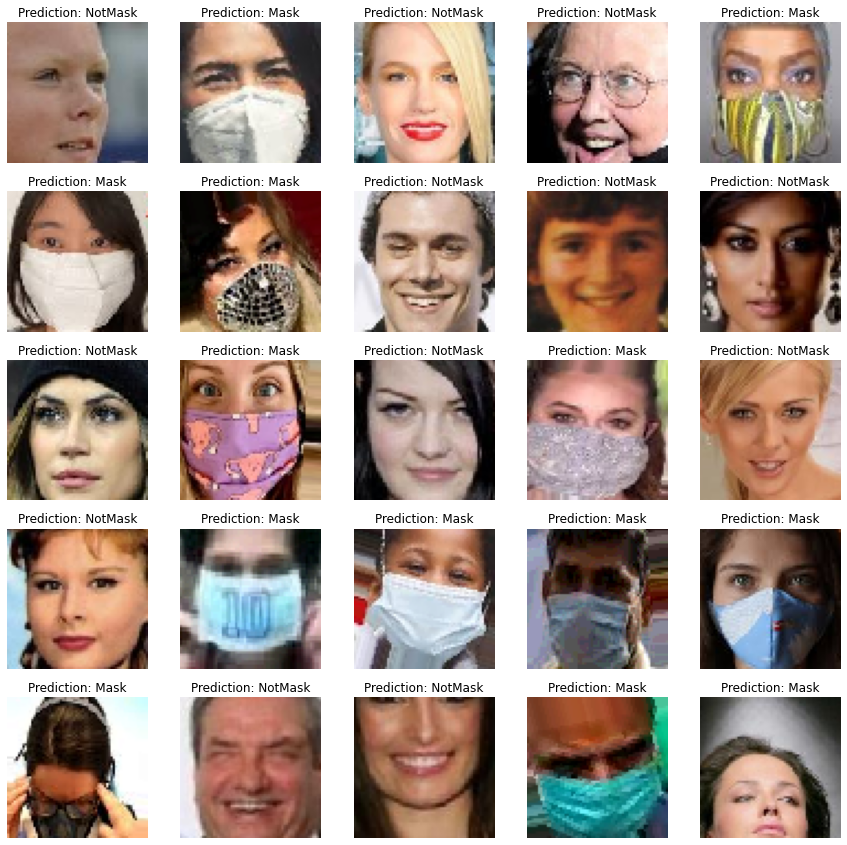

In [43]:
plot_generator_predictions(val_generator)

In [47]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)

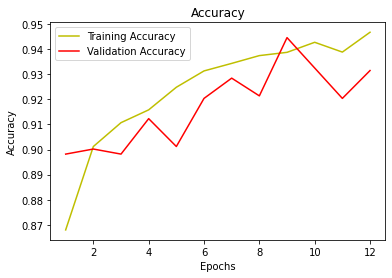

In [48]:
plt.plot(epochs, accuracy, "y", label="Training Accuracy")
plt.plot(epochs, val_accuracy, "r", label="Validation Accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

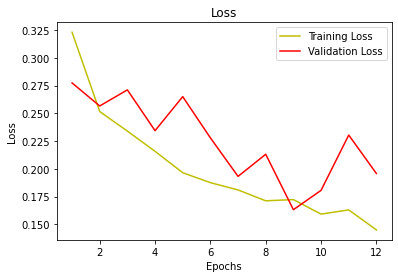

In [50]:
plt.plot(epochs, loss, "y", label="Training Loss")
plt.plot(epochs, val_loss, "r", label="Validation Loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [51]:
model.save("model.h5")

In [52]:
import tensorflow as tf

model = tf.keras.models.load_model("/content/model.h5")

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("model.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpolhuoxy1/assets


8377928

#Implemented By Muhammad Hanan Asghar